# SEDflow fails for a handful of NSA galaxies 
In this notebook, I'll take a look at what might be causing this. 

In [1]:
import os, sys
import numpy as np
from scipy import stats
from sedflow import obs as Obs
from sedflow import train as Train

In [2]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## load NSA observations

In [3]:
# u, g, r, i, z, sigma_u, sigma_g, sigma_r, sigma_i, sigma_z, redshift 
y_nsa = Obs.load_nsa_data(test_set=False)

/home/chhahn/projects/SEDflow/src/sedflow/train.py:106: RuntimeWarning: invalid value encountered in log10
  return 22.5 - 2.5 * np.log10(flux)


## load training data

In [4]:
# load training data (theta_sps, mag, sig, z)
_, y_train = Train.load_data('train', version=1, sample='toy', params='thetas_unt')

# load in the posteriors

In [5]:
sample = 'toy'
itrain = 2
nhidden = 500
nblocks = 15

igals = []
posts = [] 
for ichunk in range(3): 
    fpost = os.path.join(Train.data_dir(), 'anpe_thetaunt_magsigz.%s.%ix%i.%i.nsa%iof34.samples.npy' % (sample, nhidden, nblocks, itrain, ichunk))
    if not os.path.isfile(fpost): continue
    post = np.load(fpost)
    
    fail = (np.sum(np.sum(post, axis=2), axis=1) == 0)
    
    posts.append(post[fail])

    igals.append(np.arange(y_nsa.shape[0])[ichunk*1000:(ichunk+1)*1000][fail])

igals = np.concatenate(igals)
posts = np.concatenate(posts)

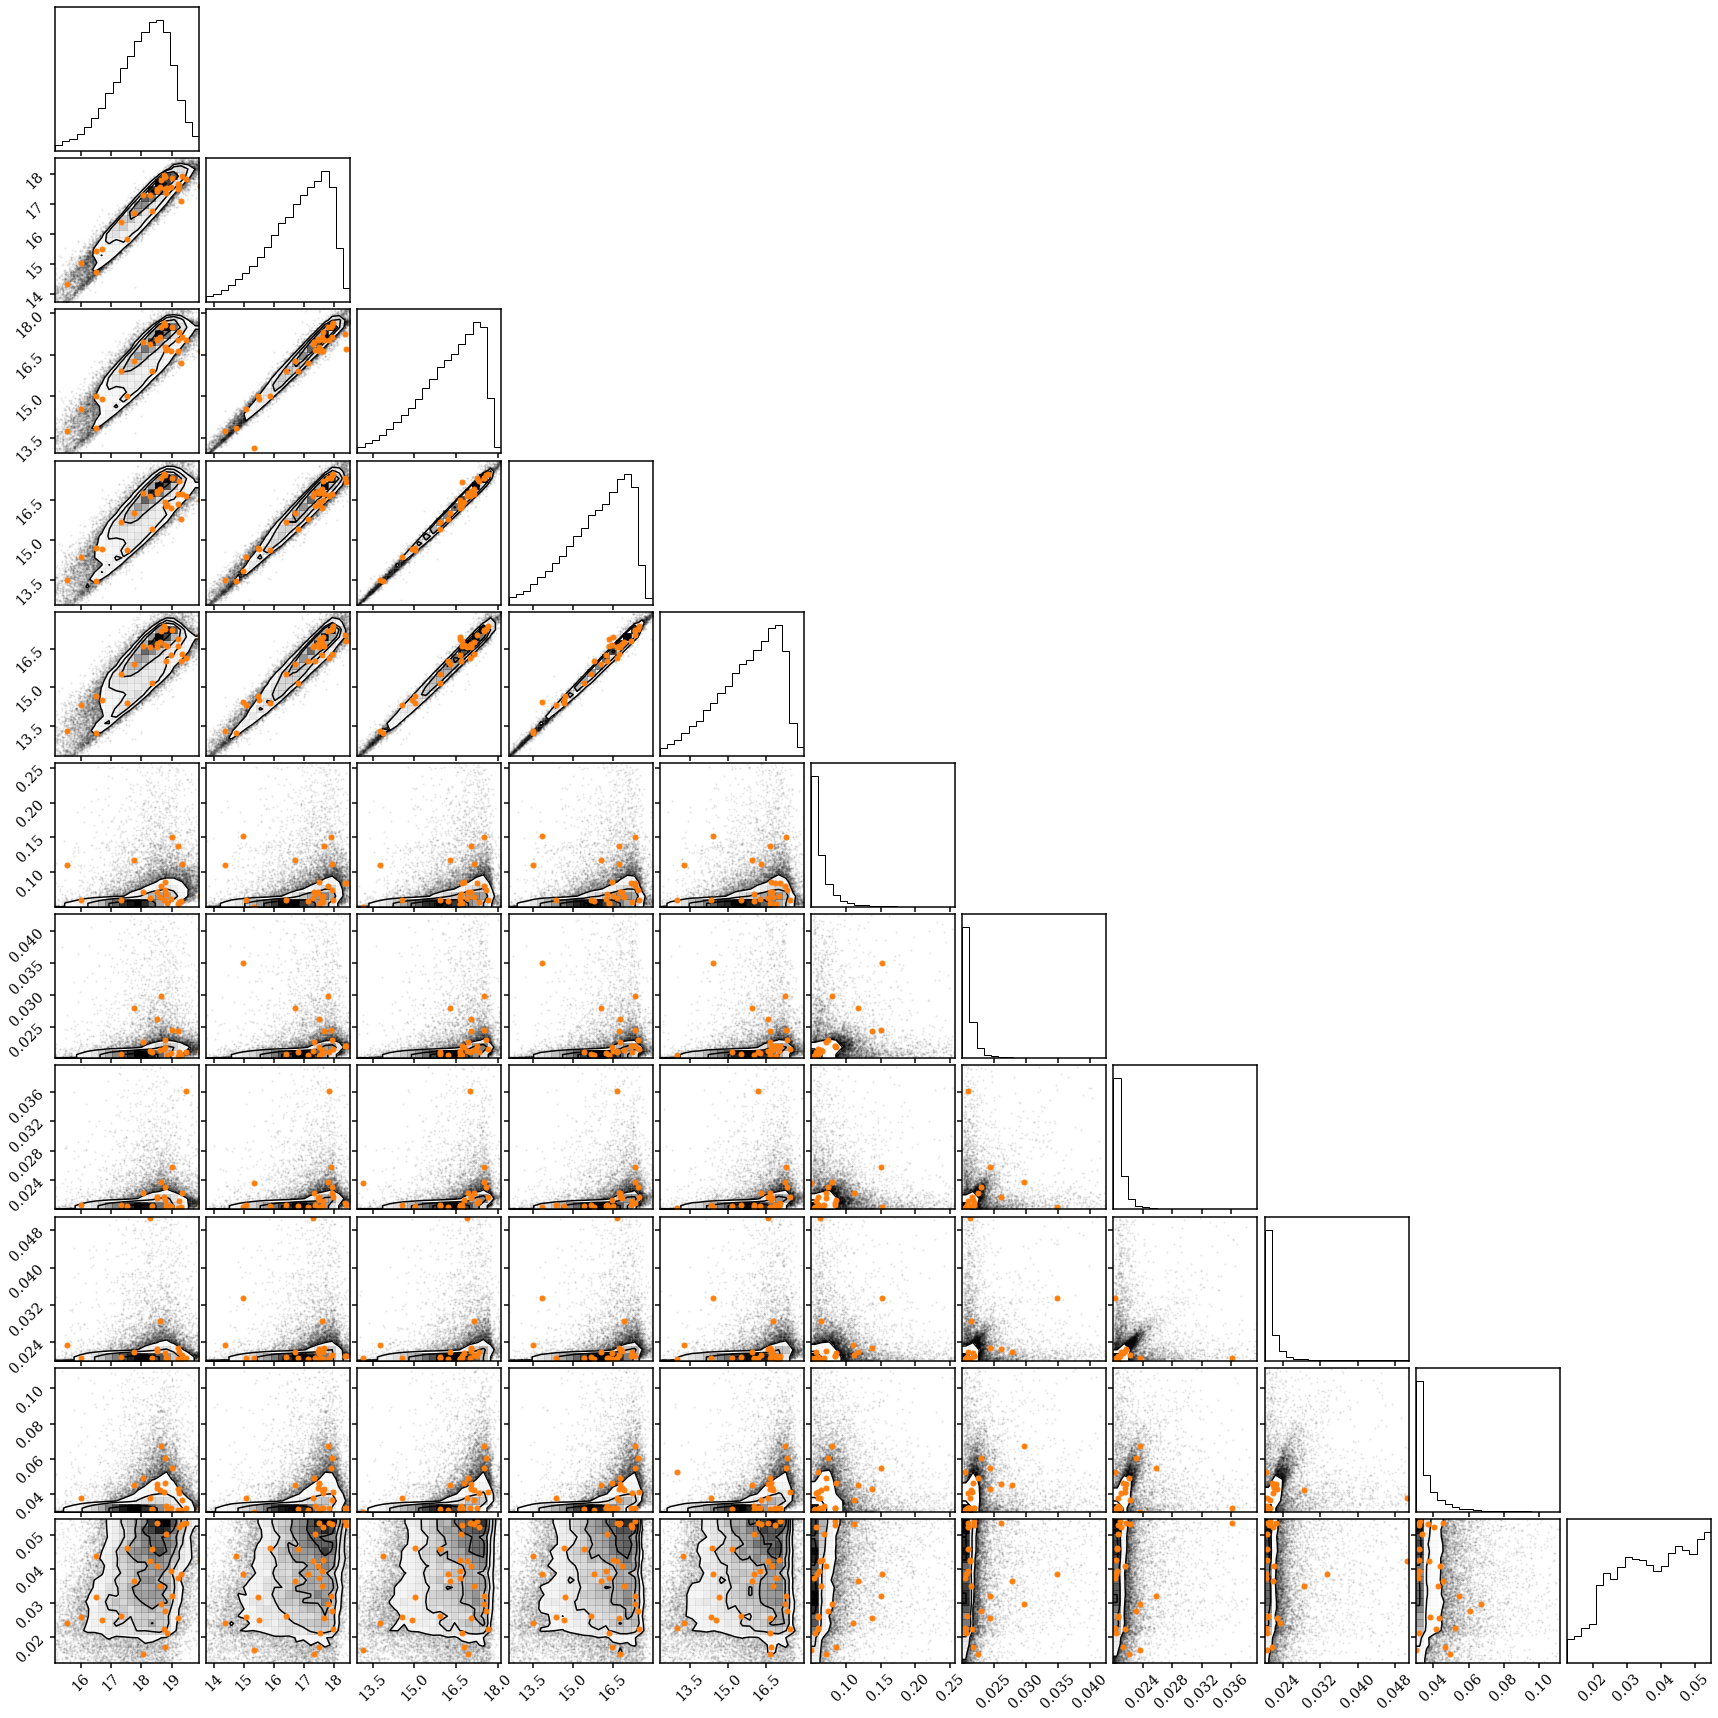

In [6]:
fig = DFM.corner(y_nsa, range=[np.nanquantile(y_nsa[:,i], [0.01, 0.99]) for i in range(y_nsa.shape[1])])
DFM.overplot_points(fig, y_nsa[igals,:], color='C1', markersize=10)

[18.622578   17.593967   17.135893   16.925743   16.775047    0.0647995
  0.02134595  0.11616991  0.02858805  0.04235177  0.0351418 ]
[1.6517021e+01 1.5453623e+01 1.5007233e+01 1.4719762e+01 1.4645347e+01
 7.6429398e+01 2.1556934e+03 2.6193739e+05 3.2899960e+02 2.5657341e-01
 3.1748787e-02]
[15.537796   14.339226   13.766681   13.491584   13.284576    0.10999763
  0.07909865  0.05185781  0.02335906  2.3410287   0.02414819]


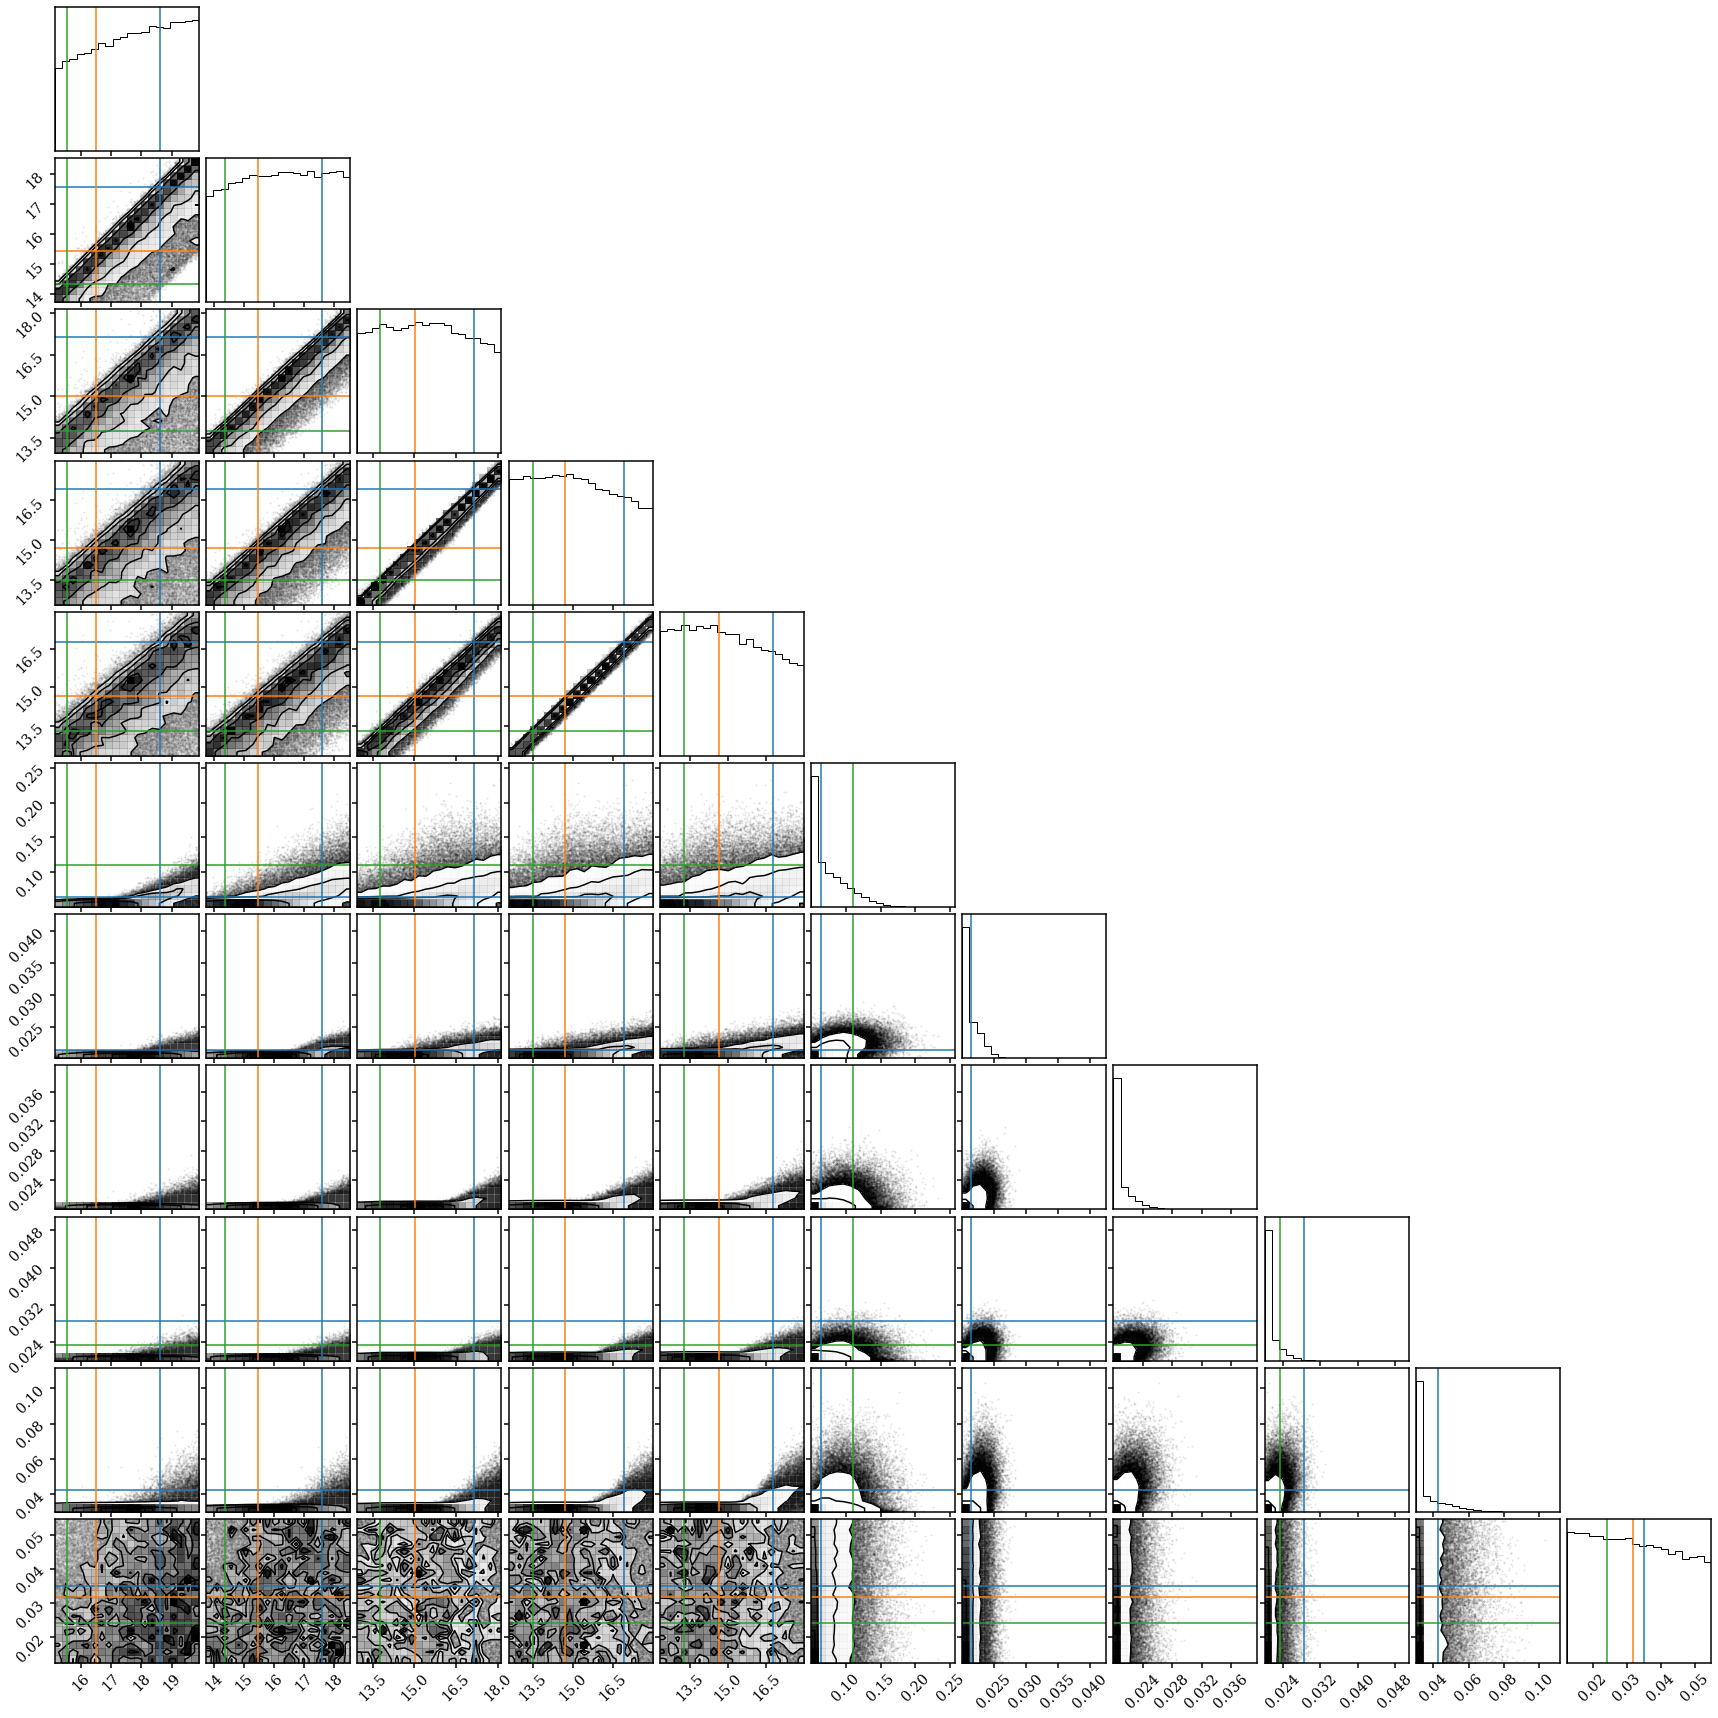

In [7]:
fig = DFM.corner(y_train[::10,:], range=[np.nanquantile(y_nsa[:,i], [0.01, 0.99]) for i in range(y_nsa.shape[1])])
for ii, igal in enumerate([1078, 1112, 1116]): 
    print(y_nsa[igal,:])
    DFM.overplot_lines(fig, y_nsa[igal,:], color='C%i' % ii)

In [8]:
# get u - g, u - r, u - i, u - z, g - r, g - i, g - z, r - i, r - z, i - z
nsa_color = [] 
train_color = [] 

for i in range(5): 
    for j in range(5): 
        if j >= i: continue
        
        nsa_color.append(y_nsa[:,i] - y_nsa[:,j])
        train_color.append(y_train[:,i] - y_train[:,j])
        
nsa_color = np.array(nsa_color).T
train_color = np.array(train_color).T

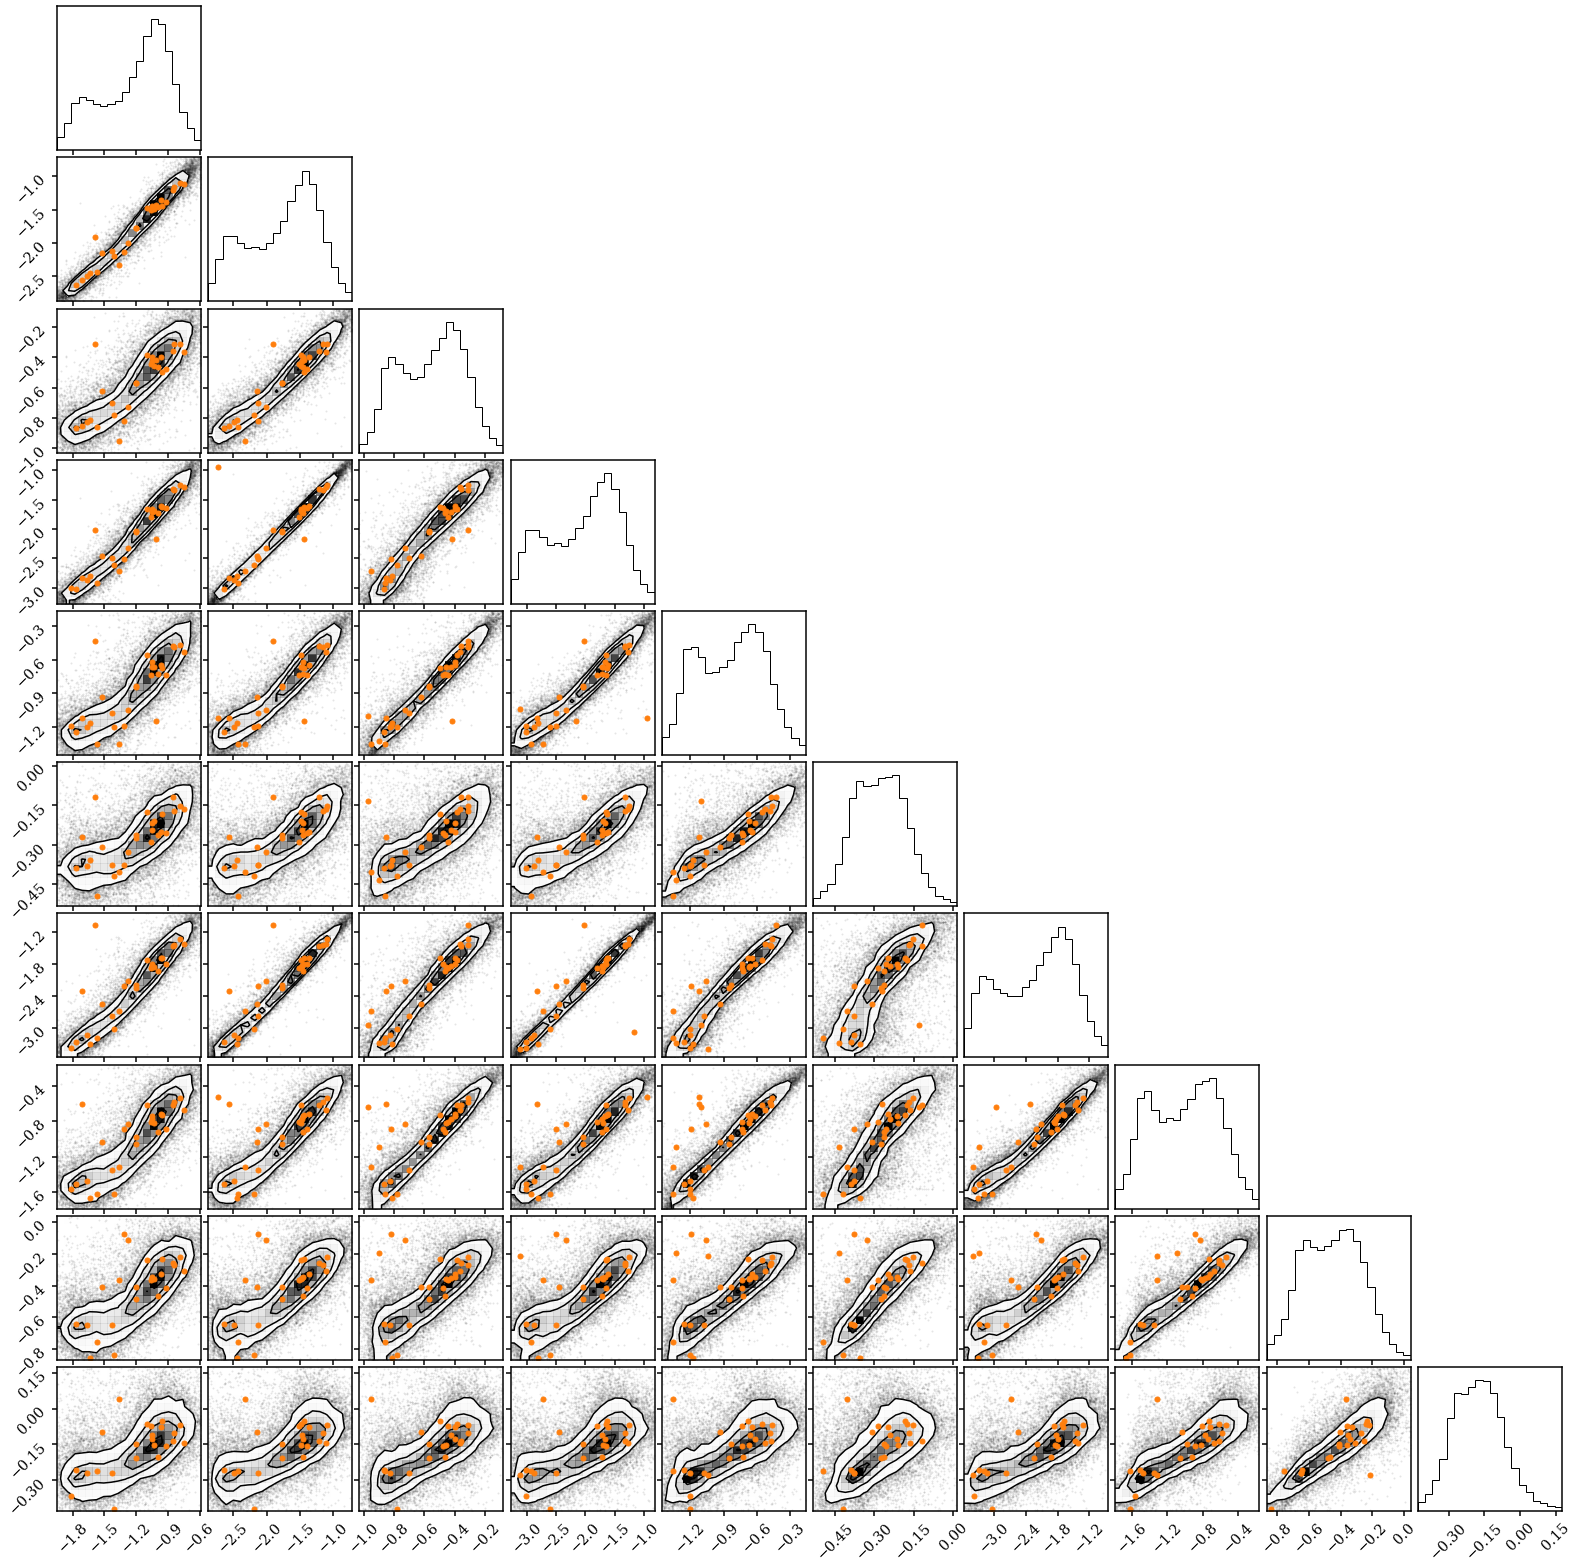

In [9]:
fig = DFM.corner(nsa_color, range=[np.nanquantile(nsa_color[:,i], [0.01, 0.99]) for i in range(nsa_color.shape[1])])
DFM.overplot_points(fig, nsa_color[igals,:], color='C1', markersize=10)

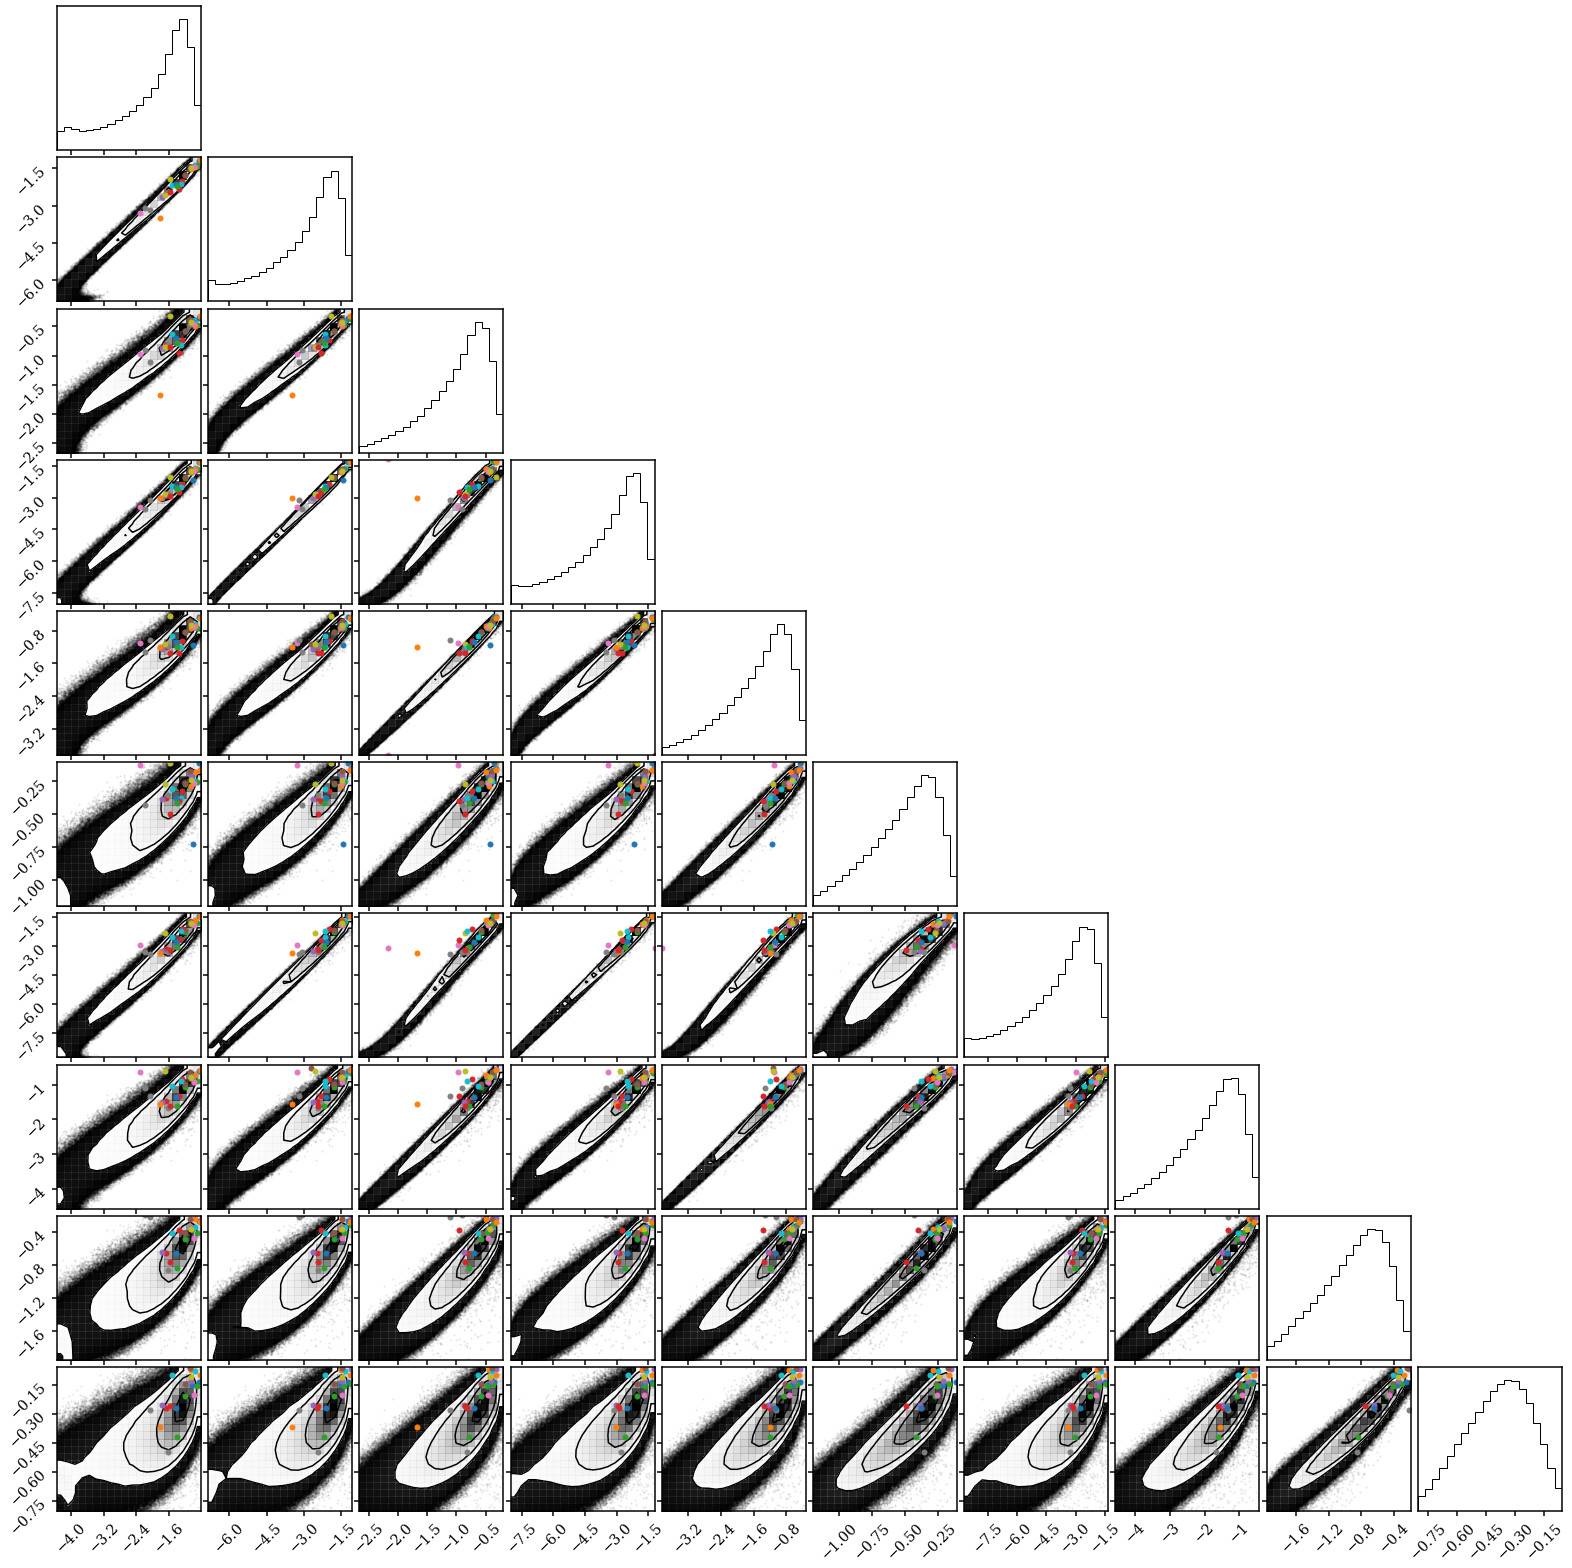

In [10]:
fig = DFM.corner(train_color, range=[np.nanquantile(train_color[:,i], [0.01, 0.99]) for i in range(train_color.shape[1])])
for ii, igal in enumerate(igals): 
    DFM.overplot_points(fig, [nsa_color[igal,:]], color='C%i' % ii, markersize=10)